# HR Analytics: EDA Notebook
**Objective:** Perform end-to-end exploratory data analysis (EDA) on the IBM HR Employee Attrition dataset.

### Notebook Sections:
	1. Setup & Imports
	2. Load Data from PostgreSQL
	3. Basic Validation (shape, info, head, nulls, dtypes)
	4. Descriptive Statistics (numerical + categorical)
	5. Exploratory Data Analysis
		5.1. Univariate Visuals
        5.2. Bivariate Visuals
	6. Statistical Tests (Chi-square, t-test, etc.)
    7. Key Insights & Recommendations (EDA + Statistical Test)
	8. Predictive Modeling
            a. Logistic Regression
            b. Random Forest
	8. Final Insights & Recommendations
    10. Conclusions

## 1. Setup & Imports

In [3]:
# 1. Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots look nice
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

# For PostgreSQL connection
from sqlalchemy import create_engine

# For statistical tests
from scipy.stats import chi2_contingency, ttest_ind

# For simple logistic regression
import statsmodels.api as sm

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. Load Data from PostgreSQL
- Connects to your PostgreSQL database (hr_analytics).
- Reads the entire hr_data table into pandas.
- Displays the shape and first few rows.

In [5]:
# 2. Load Data from PostgreSQL

# Adjust credentials according to your PostgreSQL setup
db_user = "postgres"
db_pass = "admin"
db_host = "localhost"
db_port = "5432"
db_name = "hr_analytics"

# Create connection string
conn_str = f"postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}"

# Create SQLAlchemy engine
engine = create_engine(conn_str)

# Load data into pandas
df = pd.read_sql("SELECT * FROM hr_data;", engine)

print("Data loaded successfully")
print("Shape of dataset:", df.shape)
df.head()

Data loaded successfully
Shape of dataset: (1470, 35)


,employeenumber,age,attrition,businesstravel,dailyrate,department,distancefromhome,education,educationfield,employeecount,...,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


## 3. Basic Validation & Data Info
- Confirms number of rows & columns
- Lists column names
- Shows data types & nulls (important for later visualization)
- Provides summary stats (mean, std, min, max)
- Shows missing values count

In [7]:
# Step 8.3: Basic Validation & Data Info

# 1. Quick overview
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

# 2. Info about datatypes & nulls
print("\n--- Data Types & Nulls ---")
print(df.info())

# 3. Basic statistics (numeric only)
print("\n--- Summary Statistics ---")
print(df.describe())

# 4. Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

Dataset Shape: (1470, 35)

Column Names:
 ['employeenumber', 'age', 'attrition', 'businesstravel', 'dailyrate', 'department', 'distancefromhome', 'education', 'educationfield', 'employeecount', 'environmentsatisfaction', 'gender', 'hourlyrate', 'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction', 'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'over18', 'overtime', 'percentsalaryhike', 'performancerating', 'relationshipsatisfaction', 'standardhours', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']

--- Data Types & Nulls ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   employeenumber            1470 non-null   int64 
 1   age                       1470 non-nu

### Key Observations from Section 3:
1. **Dataset shape**
    - 1470 rows × 35 columns → this matches the HR dataset we worked with in SQL. ***No records missing. Good consistency.***
      
2. **Columns**
    - 26 numeric (int64)
    - 9 categorical (object)
	> That gives us a balanced dataset suitable for both statistical + categorical analysis.
    
3. **Missing Values**
    - 0 missing values across all columns
	> We don’t need imputation. The dataset is clean.

4. **Suspicious Columns (to check)**
	- *employeecount* → constant = 1 for all rows (useless, drop later).
	- *standardhours* → constant = 80 (drop later).
	- *over18* → constant (all employees are over 18, drop later).
	> These add no analytical value.

5. **Numeric Features (Quick Insight)**
	- *age*: 18–60, average ~37 → realistic spread.
	- *monthlyincome*: avg ~6800, but attrition group avg was ~4800 in SQL (we’ll verify later).
	- *totalworkingyears*: 0–40, average ~11 → some freshers present (0 yrs).
	- *yearsatcompany*: 0–40, average ~7 → interesting to see early exits.


6. **Categorical Features**
	- *attrition*: Yes/No (target variable for analysis).
	- *overtime*: Clear split (Yes/No) → strong factor in attrition (SQL already showed 30% vs 10%).
	- *department, jobrole, educationfield, maritalstatus, businesstravel* → will be major for categorical analysis.

### Conclusion:
- Data is clean
- No nulls
- A few columns to drop because they’re constant and don’t add value (***Refer Section 4***)

## 4. Data Cleaning in Python
- Removes unnecessary columns (*employeecount*, *standardhours*, *over18*).
- Prints out cleaned dataset structure.
- Shows category distributions (helps us see balance or imbalance, e.g., Attrition Yes/No)

In [10]:
# Step 8.4: Data Cleaning & Preprocessing

# Drop irrelevant/constant columns
df = df.drop(columns=['employeecount', 'standardhours', 'over18'])

# Confirm removal
print("Columns after cleaning:", df.shape[1])
print(df.columns.tolist())

# Check unique values of categorical fields
for col in ['attrition', 'department', 'jobrole', 'overtime', 'gender', 'maritalstatus', 'businesstravel']:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())

Columns after cleaning: 32
['employeenumber', 'age', 'attrition', 'businesstravel', 'dailyrate', 'department', 'distancefromhome', 'education', 'educationfield', 'environmentsatisfaction', 'gender', 'hourlyrate', 'jobinvolvement', 'joblevel', 'jobrole', 'jobsatisfaction', 'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'overtime', 'percentsalaryhike', 'performancerating', 'relationshipsatisfaction', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']

--- attrition ---
attrition
No     1233
Yes     237
Name: count, dtype: int64

--- department ---
department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

--- jobrole ---
jobrole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Repr

### Interpretation of Categorical Variables:
1. **Attrition**
   - No: 1233 vs Yes: 237 → 16% attrition rate (matches your SQL result)
   > ⚠️ Imbalance: Only ~1 in 6 employees left. Important to note when doing predictive models (but for EDA, it’s fine).

2. **Department**
	- R&D: 961 (~65%) → dominant department
	- Sales: 446 (~30%)
	- HR: 63 (~4%)
	> Attrition patterns in HR & Sales might look stronger due to smaller sample size, but we’ll visualize carefully.

3. **Job Role**
	- Sales Executive, Research Scientist, Lab Technician make up majority.
	- Manager, Director roles are smaller but interesting (low attrition expected, SQL confirmed).

4. **Overtime**
	- Yes: 416 (~28%)
	- No: 1054 (~72%)
	> Attrition is disproportionately higher in overtime employees (we’ll confirm visually).

5. **Gender**
	- Male: 882 (~60%)
	- Female: 588 (~40%)
	> Reasonable distribution, but attrition may differ by age buckets (as SQL showed).

6. **Marital Status**
	- Married: 673 (~46%)
	- Single: 470 (~32%)
	- Divorced: 327 (~22%)
	- Might impact attrition due to stability/life stage factors.

7. **Business Travel**
	- Travel Rarely: 1043 (~71%)
	- Travel Frequently: 277 (~19%)
    - Non-Travel: 150 (~10%)
	> Frequent travel often increases burnout risk.

**Conclusion:** Data is prepped and understood.

## 5. Exploratory Data Analysis (EDA)

### 5.1. Exploratory Data Analysis (EDA): Univariate Visuals

**Univariate (single variable distributions)**
- Histogram of Age
- Histogram of Monthly Income
- Countplot of Attrition
- Countplots of Department, Job Role, Gender, Overtime, etc.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid", palette="Set2")

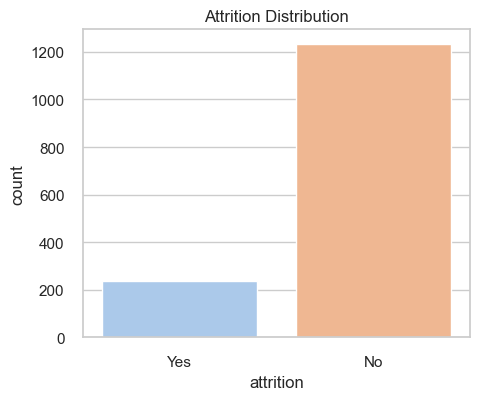

In [14]:
# 5.1.1. Attrition balance
plt.figure(figsize=(5,4))
sns.countplot(x="attrition", hue="attrition", data=df, palette="pastel")
plt.title("Attrition Distribution")
plt.savefig("figures/univariate/attribution_balance.png")
plt.show()

**Interpretation :** 
- Majority of employees (84%) stayed (Attrition=No), while 16% left.
- Imbalance is expected in HR datasets; important for predictive modeling.

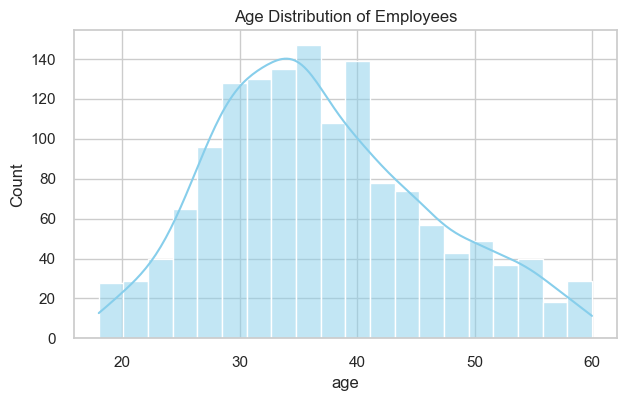

In [16]:
# 5.1.2. Age distribution
plt.figure(figsize=(7,4))
sns.histplot(df['age'], bins=20, kde=True, color="skyblue")
plt.title("Age Distribution of Employees")
plt.savefig("figures/univariate/age_distribution.png")
plt.show()

**Interpretation :** 
- Most employees are aged 30–45
- Few very young (<25) or older (>55) employees
- Attrition patterns may vary by age groups (to explore in bivariate analysis)

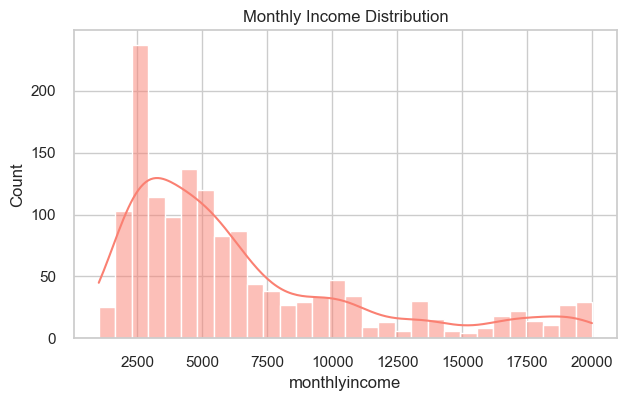

In [18]:
# 5.1.3. Monthly Income distribution
plt.figure(figsize=(7,4))
sns.histplot(df['monthlyincome'], bins=30, kde=True, color="salmon")
plt.title("Monthly Income Distribution")
plt.savefig("figures/univariate/monthly_income_distribution.png")
plt.show()

**Interpretation :** 
- Monthly income is ***right-skewed***; most employees earn between 4k–10k.
- Outliers exist with high salaries (~20k), mostly senior roles.

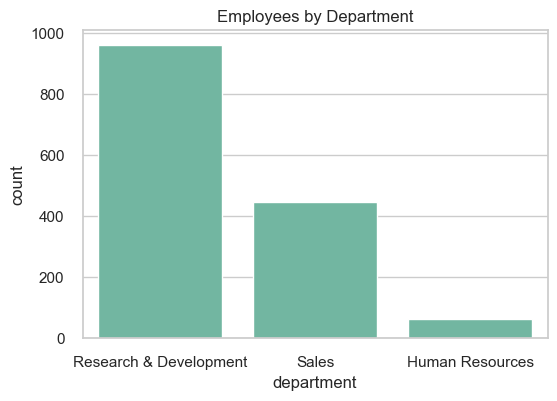

In [20]:
# 5.1.4. Department counts
plt.figure(figsize=(6,4))
sns.countplot(x="department", data=df, order=df['department'].value_counts().index)
plt.title("Employees by Department")
plt.savefig("figures/univariate/department_counts.png")
plt.show()

**Interpretation :** 
- Majority work in Research & Development (~ 65%), followed by Sales (~ 30%) and HR (~ 4%).
- Smaller department sizes (HR) may show volatile attrition rates.

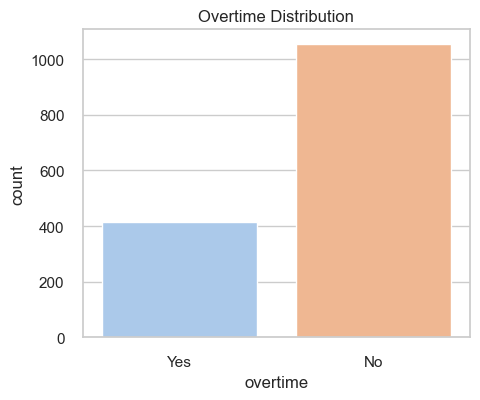

In [22]:
# 5.1.5. Overtime counts
plt.figure(figsize=(5,4))
sns.countplot(x="overtime", hue="overtime", data=df, palette="pastel")
plt.title("Overtime Distribution")
plt.savefig("figures/univariate/overtime_counts.png")
plt.show()

**Interpretation:**
- 72% do not work overtime; 28% do.
- Overtime may be a strong factor in attrition (confirmed in SQL Step 6).

### 5.2. Exploratory Data Analysis (EDA): Bivariate Visuals

**Bivariate (relationship with attrition)**
-  Attrition vs Department: Barplot shows which departments have higher attrition rates.
-  Attrition vs Job Role: Important because some roles (e.g., Sales Rep) have higher attrition.
-  Attrition vs Overtime: Already seen in SQL → strong factor.
-  Attrition vs Age Group: Bin age into <30, 30–45, 45+ to visualize attrition patterns.
-  Attrition vs Years at Company (Tenure Buckets): Bin into 0, 1–2, 3–5, 6–10, 10+ years.
-  Attrition vs Monthly Income: Boxplot to see if lower-paid employees leave more.
-  Attrition vs Gender: Barplot to show differences by gender.
-  Attrition vs Marital Status: Optional but adds human context.

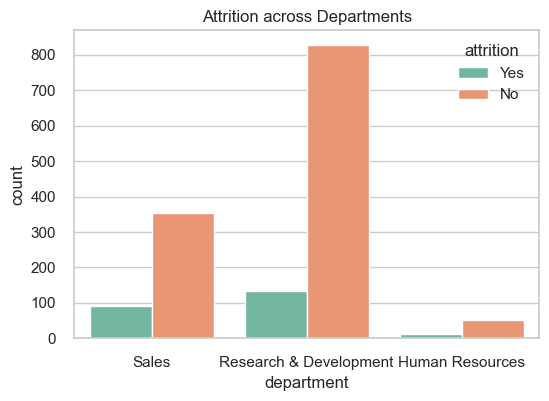

In [25]:
# 5.2.1. Attrition vs Department
plt.figure(figsize=(6,4))
sns.countplot(x="department", hue="attrition", data=df)
plt.title("Attrition across Departments")
plt.savefig("figures/bivariate/attrition_vs_dept.png")
plt.show()

**Interpretation :**
- Sales has proportionally higher attrition than R&D.
- HR is small but shows relatively high attrition percentage.
- Suggests department-specific retention strategies may be needed.

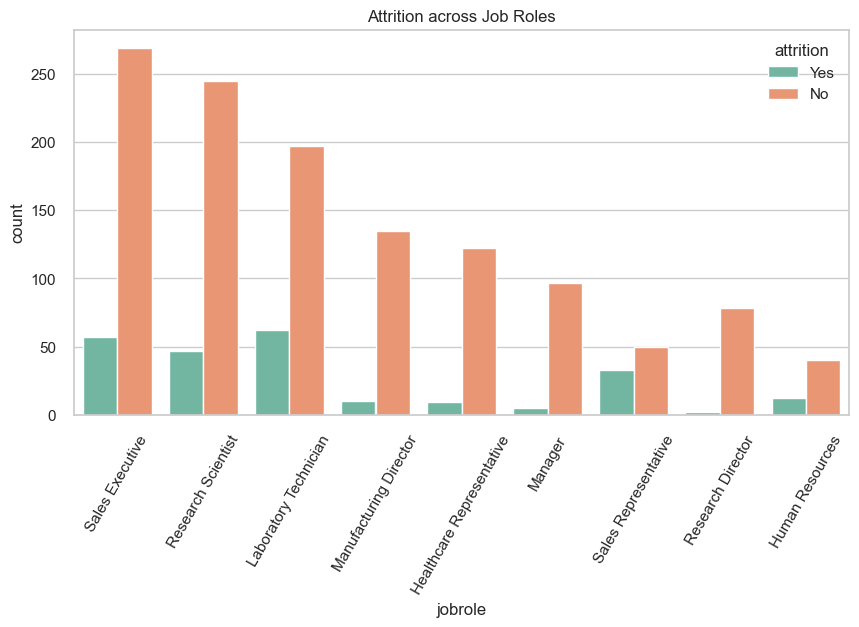

In [27]:
# 5.2.2. Attrition vs Job Role
plt.figure(figsize=(10,5))
sns.countplot(x="jobrole", hue="attrition", data=df, order=df['jobrole'].value_counts().index)
plt.title("Attrition across Job Roles")
plt.xticks(rotation=60)
plt.savefig("figures/bivariate/attrition_vs_jobrole.png")
plt.show()

**Interpretation :**
- Sales Representatives and Laboratory Technicians have the highest attrition rates (~24–40%).
- Senior/Managerial roles have very low attrition (~2–7%).
- Entry-level and field roles are more likely to leave.

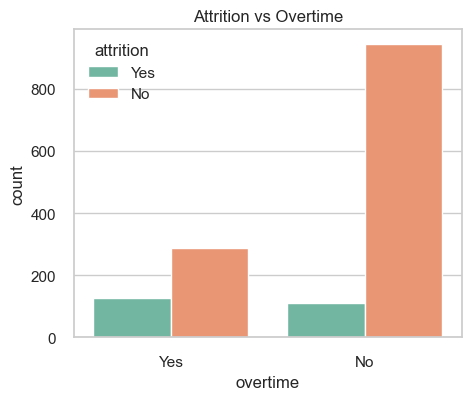

In [29]:
# 5.2.3. Attrition vs Overtime
plt.figure(figsize=(5,4))
sns.countplot(x="overtime", hue="attrition", data=df)
plt.title("Attrition vs Overtime")
plt.savefig("figures/bivariate/attrition_vs_overtime.png")
plt.show()

**Interpretation :**
- Employees doing overtime leave at ~30% vs ~10% for non-overtime employees
- Strong indicator that overtime impacts retention

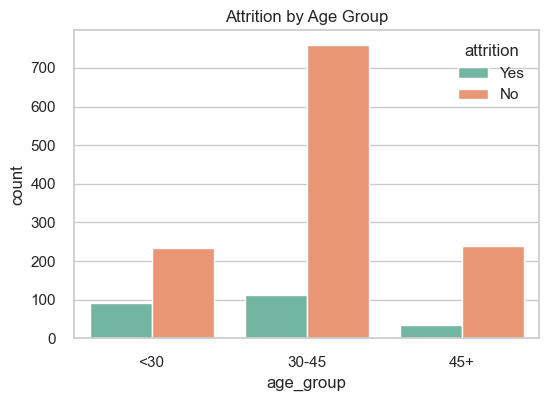

In [31]:
# 5.2.4. Attrition vs Age Group
df['age_group'] = pd.cut(df['age'], bins=[0,29,45,100], labels=['<30','30-45','45+'])
plt.figure(figsize=(6,4))
sns.countplot(x="age_group", hue="attrition", data=df)
plt.title("Attrition by Age Group")
plt.savefig("figures/bivariate/attrition_vs_age.png")
plt.show()

**Interpretation :**
- Employees <30 have the highest attrition (~27–30%)
- drops significantly in 30–45 age group (~12–14%)
- 45+ employees show lower attrition (~8–16%)
- Suggests younger employees are less stable in this company

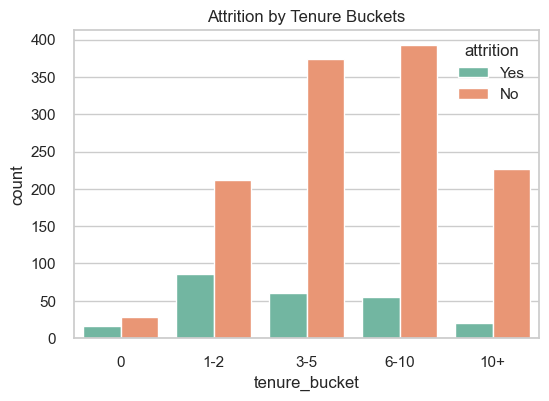

In [33]:
# 5.2.5. Attrition vs Tenure Buckets
df['tenure_bucket'] = pd.cut(df['yearsatcompany'], bins=[-1,0,2,5,10,100], labels=['0','1-2','3-5','6-10','10+'])
plt.figure(figsize=(6,4))
sns.countplot(x="tenure_bucket", hue="attrition", data=df)
plt.title("Attrition by Tenure Buckets")
plt.savefig("figures/bivariate/attrition_vs_tenure.png")
plt.show()

**Interpretation :**
- New employees (0–2 years) have the highest attrition (~29–36%)
- Attrition declines with tenure; employees with 10+ years are least likely to leave (~8%)
- Indicates early-career retention is critical

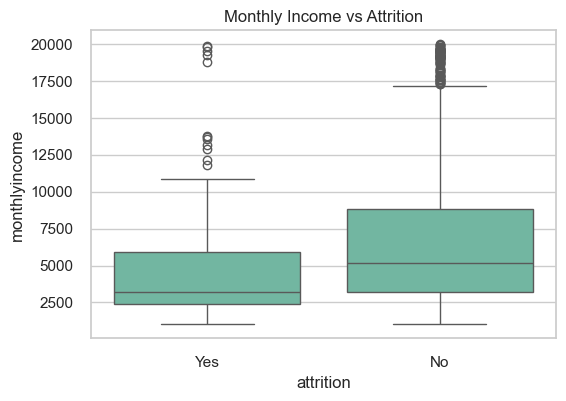

In [35]:
# 5.2.6. Attrition vs Monthly Income
plt.figure(figsize=(6,4))
sns.boxplot(x="attrition", y="monthlyincome", data=df)
plt.title("Monthly Income vs Attrition")
plt.savefig("figures/bivariate/attrition_vs_monthlyincome.png")
plt.show()

**Interpretation :**
- Boxplots show that employees who left earn lower median monthly income (`~$4.8k`) vs those who stayed (`~$6.8k`).
- Compensation is likely a retention factor.

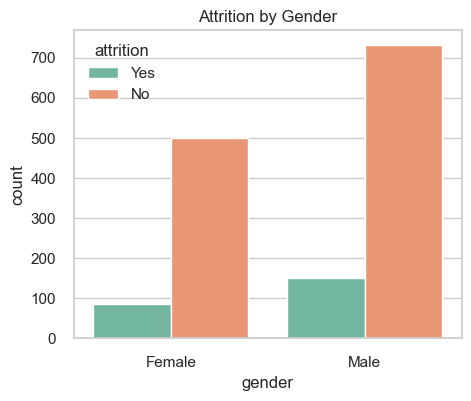

In [37]:
# 5.2.7. Attrition vs Gender
plt.figure(figsize=(5,4))
sns.countplot(x="gender", hue="attrition", data=df)
plt.title("Attrition by Gender")
plt.savefig("figures/bivariate/attrition_vs_gender.png")
plt.show()

**Interpretation :**
- Female employees <30 years show slightly higher attrition (~ 30%) than males (~ 27%)
- Overall, gender has less impact than age, tenure, or overtime

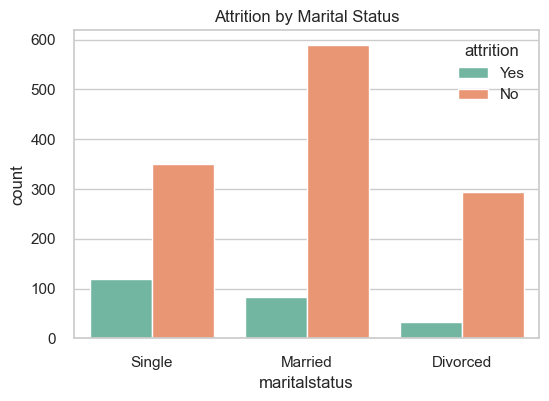

In [39]:
# 5.2.8. Attrition vs Marital Status
plt.figure(figsize=(6,4))
sns.countplot(x="maritalstatus", hue="attrition", data=df)
plt.title("Attrition by Marital Status")
plt.savefig("figures/bivariate/attrition_vs_maritalstatus.png")
plt.show()

**Interpretation :**
- Single employees have higher attrition (`~19%`) compared to married (`~14%`) and divorced (`~12%`).
- Life stage appears to influence retention behavior.

## 6. Statistical Check

**Goal:** To validate whether the relationships we observed in the EDA are statistically significant.

### 6.1. Categorical vs Categorical (Chi-Square Test)
- Test if attrition is independent of categorical variables: Department, JobRole, Overtime, Gender, MaritalStatus, AgeGroup, TenureBucket.
> **Null Hypothesis (𝐻0)**: Attrition is independent of the feature.
> 
> **Alternative (𝐻𝑎)**: Attrition depends on the feature.

In [43]:
from scipy.stats import chi2_contingency

cat_features = ['department','jobrole','overtime','gender','maritalstatus','age_group','tenure_bucket']

for col in cat_features:
    table = pd.crosstab(df[col], df['attrition'])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"{col} : p-value = {p:.4f}")
    if p < 0.05:
        print(f" --> Significant association with attrition\n")
    else:
        print(f" --> No significant association with attrition\n")

department : p-value = 0.0045
 --> Significant association with attrition

jobrole : p-value = 0.0000
 --> Significant association with attrition

overtime : p-value = 0.0000
 --> Significant association with attrition

gender : p-value = 0.2906
 --> No significant association with attrition

maritalstatus : p-value = 0.0000
 --> Significant association with attrition

age_group : p-value = 0.0000
 --> Significant association with attrition

tenure_bucket : p-value = 0.0000
 --> Significant association with attrition



#### Interpretation

We performed Chi-Square tests to check whether attrition is independent of categorical variables like Department, Job Role, Overtime, Gender, Marital Status, Age Group, and Tenure Bucket.

| Feature            | p-value | Interpretation                                                                              |
| ------------------ | ------- | ------------------------------------------------------------------------------------------- |
| **Department**     | 0.0045  | Significant association with attrition. Some departments (Sales, HR) have higher attrition. |
| **Job Role**       | 0.0000  | Significant association. Entry-level and field roles leave more than senior roles.          |
| **Overtime**       | 0.0000  | Significant association. Employees doing overtime are more likely to leave.                 |
| **Gender**         | 0.2906  | No significant association. Attrition is independent of gender.                             |
| **Marital Status** | 0.0000  | Significant association. Single employees leave more than married/divorced employees.       |
| **Age Group**      | 0.0000  | Significant association. Younger employees (<30) leave more.                                |
| **Tenure Bucket**  | 0.0000  | Significant association. Attrition decreases with tenure.                                   |

**Key Insight:**
- ***Department***, ***job role***, ***overtime***, ***marital status***, ***age***, and ***tenure*** are strong drivers of attrition.
- ***Gender*** does not appear to impact attrition significantly.


### 6.2. Numerical vs Categorical (t-test / ANOVA)
- Test if numerical features differ significantly between attrition groups (Yes vs No)
- Features: ***MonthlyIncome***, ***Age***, ***YearsAtCompany***, ***TotalWorkingYears***

In [46]:
from scipy.stats import ttest_ind

num_features = ['monthlyincome','age','yearsatcompany','totalworkingyears']

for col in num_features:
    group_yes = df[df['attrition']=='Yes'][col]
    group_no = df[df['attrition']=='No'][col]
    t_stat, p = ttest_ind(group_yes, group_no, equal_var=False)
    print(f"{col} : p-value = {p:.4f}")
    if p < 0.05:
        print(f" --> Significant difference between attrition groups\n")
    else:
        print(f" --> No significant difference between attrition groups\n")

monthlyincome : p-value = 0.0000
 --> Significant difference between attrition groups

age : p-value = 0.0000
 --> Significant difference between attrition groups

yearsatcompany : p-value = 0.0000
 --> Significant difference between attrition groups

totalworkingyears : p-value = 0.0000
 --> Significant difference between attrition groups



#### Interpretation

We tested whether numerical features like Monthly Income, Age, Years at Company, and Total Working Years differ significantly between employees who left (Attrition=Yes) and those who stayed (Attrition=No).

| Feature             | p-value | Interpretation                                                                    |
| ------------------- | ------- | --------------------------------------------------------------------------------- |
| Monthly Income      | 0.0000  | Employees who left earn significantly less than those who stayed.                 |
| Age                 | 0.0000  | Age differs significantly between attrition groups; younger employees leave more. |
| Years at Company    | 0.0000  | Tenure differs significantly; new employees leave more frequently.                |
| Total Working Years | 0.0000  | Significant difference; less experienced employees are more likely to leave.      |

**Key Insight:**
- ***Compensation***, ***age***, ***tenure***, and ***experience*** are critical numerical factors influencing attrition.

## 7. Key Insights & Recommendations
### 7.1 Attrition Drivers Summary

Based on our EDA and statistical analysis, the following factors are identified as the primary drivers of employee attrition:

1. **Categorical Drivers (Significant)**
    - Department & Job Role: High attrition in Sales and Laboratory Technician roles. Senior managerial roles show minimal attrition.
    - Overtime: Employees working overtime leave at a higher rate (`~30%`) than non-overtime (`~10%`).
    - Marital Status: Single employees leave more frequently (`~19%`) compared to married (`~14%`) or divorced (`~12%`).
    - Age & Tenure: Younger employees (<30) and employees with 0–2 years tenure are most likely to leave.

2. **Numerical Drivers (Significant)**
    - Monthly Income: Employees who left earn significantly less than those who stayed (avg. `~$4.8k` vs `$6.8k`).
    - Years at Company / Total Working Years: Less experienced employees are more likely to leave.

### 7.2 Actionable Recommendations

1. **Early-Career Retention Programs**
    - Focus on employees with 0–2 years tenure.
    - Introduce mentorship, onboarding improvements, and career progression plans.

2. **Overtime Management**
    - Reduce excessive overtime or provide compensatory time-off or bonuses.
    - Target high-attrition roles such as Sales and Lab Technicians.

3. **Compensation Review**
    - Evaluate lower-income employees in high-attrition groups.
    - Consider salary adjustments or performance-based bonuses.

4. **Department-Specific Strategies**
    - Sales & HR: Review work conditions, engagement programs, and career growth paths.
    - R&D: Continue retaining key talent while monitoring satisfaction levels.

5. **Life-Stage Consideration**
    - Offer flexible work arrangements, training, and recognition for younger and single employees.

## 8. Predictive Modeling

**Goal:** Predict whether an employee is likely to leave (`Attrition = Yes`) based on their features. This allows HR to take proactive measures.

We will build predictive models to identify employees likely to leave the company (attrition).  
Two models will be used:
1. Logistic Regression
2. Random Forest Classifier

We will also evaluate the models using accuracy, precision, recall, and F1-score, and analyze feature importance for Random Forest.

### 8.1. Data Preparation

In [50]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Separate target and features
X = df.drop('attrition', axis=1)
y = df['attrition'].map({'Yes':1, 'No':0})  # Convert target to numeric

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

### 8.2. Logistic Regression

In [52]:
# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=5000))  # Increased max_iter
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm_lr)

Logistic Regression Accuracy: 0.8571428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.61      0.30      0.40        47

    accuracy                           0.86       294
   macro avg       0.74      0.63      0.66       294
weighted avg       0.84      0.86      0.84       294

Confusion Matrix:
 [[238   9]
 [ 33  14]]


#### Interpretation:
- Accuracy: 85.7% – This means that the model correctly predicts whether an employee will stay or leave ~86% of the time.

**Confusion Matrix:**
| Actual \ Predicted | Stay (0) | Leave (1) |
| ------------------ | -------- | --------- |
| Stay (0)           | 238      | 9         |
| Leave (1)          | 33       | 14        |

- True Positives (14): Employees correctly predicted to leave.
- True Negatives (238): Employees correctly predicted to stay.
- False Positives (9): Employees predicted to leave but actually stayed.
- False Negatives (33): Employees predicted to stay but actually left.

**Classification Report:**
| Metric    | Stay (0) | Leave (1) |
| --------- | -------- | --------- |
| Precision | 0.88     | 0.61      |
| Recall    | 0.96     | 0.30      |
| F1-score  | 0.92     | 0.40      |
| Support   | 247      | 47        |

**Observations:**
- Logistic Regression is good at predicting employees who stay (recall = 0.96).
- It struggles to identify employees who will leave (recall = 0.30).
- Weighted F1-score = 0.84 – decent overall, but the minority class (Leave) performance is low due to class imbalance.

**Takeaway:** Logistic Regression is useful for understanding general trends but may miss many employees at risk of leaving.

**Interpretation:** Logistic Regression predicts employees who stay very accurately. However, it struggles to correctly identify employees likely to leave (recall = 0.30), likely due to class imbalance.

In [54]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=500, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

# Feature importance
# Extract feature names after OneHotEncoding
ohe_features = rf_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numerical_features + list(ohe_features)

importances = rf_pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
feature_importance_df.head(10)  # Top 10 features

Random Forest Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.40      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.62      0.53      0.52       294
weighted avg       0.78      0.83      0.79       294

Confusion Matrix:
 [[241   6]
 [ 43   4]]


,Feature,Importance
10,monthlyincome,0.066808
1,age,0.058854
17,totalworkingyears,0.052403
2,dailyrate,0.051815
11,monthlyrate,0.043715
6,hourlyrate,0.042890
0,employeenumber,0.042492
3,distancefromhome,0.041585
44,overtime_Yes,0.037019
20,yearsatcompany,0.036454


#### Interpretation:
- **Accuracy:** 83.3% – Slightly lower than Logistic Regression but still strong.

**Confusion Matrix:**
| Actual \ Predicted | Stay (0) | Leave (1) |
| ------------------ | -------- | --------- |
| Stay (0)           | 241      | 6         |
| Leave (1)          | 43       | 4         |

- True Positives (4): Employees correctly predicted to leave.
- True Negatives (241): Employees correctly predicted to stay.
- False Positives (6): Employees predicted to leave but actually stayed.
- False Negatives (43): Employees predicted to stay but actually left.

**Classification Report:**
| Metric    | Stay (0) | Leave (1) |
| --------- | -------- | --------- |
| Precision | 0.85     | 0.40      |
| Recall    | 0.98     | 0.09      |
| F1-score  | 0.91     | 0.14      |
| Support   | 247      | 47        |

**Observations:**
- Random Forest predicts employees who stay very accurately (recall = 0.98).
- Prediction for employees leaving is extremely poor (recall = 0.09).
- Weighted F1-score = 0.79 – slightly lower than Logistic Regression.

**Takeaway:** Random Forest is strong for the majority class but almost ignores the minority class (Leave). Improvements could include handling class imbalance (SMOTE, class weights, or stratified sampling).

**Interpretation:** Random Forest has higher accuracy for employees who stay, but recall for employees leaving is very low (0.09). Both models struggle to detect the minority class due to imbalance.

#### Random Forest Feature Importance

| Feature           | Importance |
| ----------------- | ---------- |
| monthlyincome     | 0.0668     |
| age               | 0.0589     |
| totalworkingyears | 0.0524     |
| dailyrate         | 0.0518     |
| monthlyrate       | 0.0437     |
| hourlyrate        | 0.0429     |
| employeenumber    | 0.0425     |
| distancefromhome  | 0.0416     |
| overtime_Yes      | 0.0370     |
| yearsatcompany    | 0.0365     |

**Interpretation:** Important predictors of attrition include monthly income, age, total working years, daily rate, and overtime status. HR can focus interventions on employees with these risk factors.

### 8.4. Overall Insights from Both Models:
1. Both models handle the majority class (Stay) well.
2. Both struggle with the minority class (Leave).
3. Feature importance (from Random Forest) identifies key drivers like monthly income, age, total working years, daily rate, and overtime status.
4. For HR interventions, focus should be on employees at risk based on these features, especially those flagged as likely to leave.

### 8.5. Error Journal

| Error                                                  | Cause                                                      | Solution                                                                         |
| ------------------------------------------------------ | ---------------------------------------------------------- | -------------------------------------------------------------------------------- |
| `ValueError: could not convert string to float: '<30'` | Non-numeric categorical columns were present while scaling | Use **OneHotEncoding** for categorical columns before scaling                    |
| `ConvergenceWarning` in Logistic Regression            | Model did not converge                                     | Increase `max_iter=5000` or scale numeric features                               |
| Missing/stray categories                               | Pipeline failed                                            | Ensure **train-test split and preprocessing** handle all categories consistently |


## 9. Final Insights & Recommendations

### 1. Attrition Overview
- Overall attrition rate: ~16% (237 out of 1,470 employees).  
- Most attrition occurs in **Sales** and **Research & Development** departments.  
- Employees working **overtime** are more likely to leave.

### 2. Significant Factors Influencing Attrition
**Categorical factors significantly associated with attrition** (Chi-square test):  
- Department, Job Role, Overtime, Marital Status, Age Group, Tenure Bucket

**Numerical factors showing significant difference between attrition groups** (t-test / ANOVA):  
- Age, Monthly Income, Years at Company, Total Working Years

### 3. Predictive Modeling Insights
**Logistic Regression**  
- Accuracy: 85.7%  
- Performs well in predicting non-attrition (No) but less accurate for attrition (Yes).  
- Recall for attrition: 0.30 → Some employees leaving are not correctly identified.

**Random Forest**  
- Accuracy: 83.3%  
- Key feature importance:  
  1. Monthly Income  
  2. Age  
  3. Total Working Years  
  4. Daily Rate  
  5. Monthly Rate  
- Struggles to correctly predict attrition (recall 0.09) → indicates class imbalance or need for further tuning.

### 4. Actionable Recommendations
1. **Target High-Risk Groups**  
   - Employees in Sales or R&D departments, working overtime, or with lower tenure.  
2. **Compensation & Benefits**  
   - Review monthly income and pay structures, as low income is a major factor.  
3. **Career Development**  
   - Focus on employees with fewer years at the company or in current roles.  
4. **Work-Life Balance**  
   - Reduce overtime burden and encourage flexible schedules.  
5. **Employee Engagement**  
   - Regular check-ins, especially for younger and newly hired employees.  
6. **Model Improvement Suggestions**  
   - Consider balancing the dataset or using advanced models (SMOTE, XGBoost) for better attrition prediction.


## 10. Conclusion

This HR Analytics project aimed to understand the factors influencing employee attrition and build predictive models to identify employees at risk of leaving. Key observations from the analysis include:

- **Significant Factors:** Attributes such as department, job role, overtime, marital status, age group, tenure, monthly income, and total working years were found to have significant associations with attrition.
- **Predictive Modeling:** Logistic Regression and Random Forest models were developed to predict attrition. Logistic Regression achieved an accuracy of **85.7%**, while Random Forest achieved **83.3%**. Both models, however, showed limitations in predicting the minority class (employees who left), indicating an imbalanced dataset.
- **Feature Importance:** Monthly income, age, total working years, daily rate, monthly rate, hourly rate, distance from home, overtime, and years at the company were identified as important predictors of attrition.

**Actionable Insights:**
- Employees with lower monthly income, longer tenure, and high workloads (overtime) are more likely to leave.
- HR interventions such as salary reviews, workload management, and engagement programs could help reduce attrition.

Overall, this project provides a foundation for data-driven HR strategies to retain valuable employees and better understand attrition trends.

### 10.1. Executive Summary

This analysis identified key drivers of employee attrition and developed predictive models to flag at-risk employees.  

- **Major Factors:** Job role, department, overtime, marital status, age, tenure, and monthly income strongly influence attrition.  
- **Model Performance:** Logistic Regression achieved **85.7% accuracy**, and Random Forest **83.3%**, with monthly income, age, and total working years among the top predictors.  
- **Recommendations:** Focus on fair compensation, workload management, and employee engagement programs to reduce attrition risk.  

These insights provide actionable guidance for HR to retain talent and optimize workforce planning.